In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = np.load('/content/drive/My Drive/Colab Notebooks/labels.npy')
audios = np.load('/content/drive/My Drive/Colab Notebooks/audios.npy')

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
import scipy
from scipy import signal, fft
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1

In [ ]:
# https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
sr = 22050
# A2S = Audio sequence to spectrogram

# Dont convert to 64x64

def a2s(audio_sequence, sampling_rate=sr):
    cut_audio = audio_sequence#[audio_sequence!=0]

    spec = spectrogram(cut_audio, sample_rate = sampling_rate, max_freq = 11025)

    # Resize the spectrogram to 64x64 (needs normalized size)
    #spectrogram_image = cv2.resize(spec, dsize=(64, 64), interpolation=cv2.INTER_LINEAR)
    #plt.imshow(spectrogram_image)
    return spec

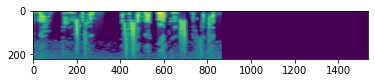

In [ ]:

test = a2s(audios[726])
plt.imshow(test)

In [ ]:
# Uncut audios
import time

start = time.time()
specs = np.apply_along_axis(a2s, 1, audios)

print(time.time() - start)

21.44297480583191


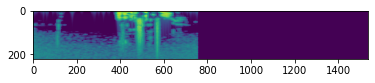

In [ ]:
# Test if they correspond correctly
plt.imshow(specs[700])

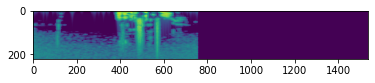

In [ ]:
plt.imshow(a2s(audios[700]))

In [ ]:
### Time to create the model.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.25)

y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral', 'other', 'X'])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral', 'other', 'X'])


In [ ]:
X_train.shape

(954, 221, 1537)

# Testing

In [ ]:
from keras.layers import Dropout

In [ ]:
model = Sequential()

# Add a 2D convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(221, 1537, 1)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second 2D convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolution layers
model.add(Flatten())

# Add a dense layer with dropout regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with 6 units (one for each emotion) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_bin, epochs=15, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)

Epoch 1/15
24/24 [==============================] - 19s 426ms/step - loss: 478.8319 - accuracy: 0.3054 - val_loss: 1.6915 - val_accuracy: 0.2880
Epoch 2/15
24/24 [==============================] - 7s 305ms/step - loss: 1.5372 - accuracy: 0.3814 - val_loss: 1.5268 - val_accuracy: 0.3927
Epoch 3/15
24/24 [==============================] - 7s 307ms/step - loss: 1.3202 - accuracy: 0.5308 - val_loss: 1.4163 - val_accuracy: 0.4241
Epoch 4/15
24/24 [==============================] - 7s 306ms/step - loss: 1.0065 - accuracy: 0.6330 - val_loss: 1.5279 - val_accuracy: 0.4555
Epoch 5/15
24/24 [==============================] - 7s 307ms/step - loss: 0.7384 - accuracy: 0.7366 - val_loss: 1.6322 - val_accuracy: 0.4555
Epoch 6/15
24/24 [==============================] - 7s 307ms/step - loss: 0.4430 - accuracy: 0.8480 - val_loss: 1.9287 - val_accuracy: 0.4555
Epoch 7/15
24/24 [==============================] - 7s 311ms/step - loss: 0.2935 - accuracy: 0.8938 - val_loss: 2.8546 - val_accuracy: 0.4503
Epo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

10/10 [==============================] - 1s 105ms/step - loss: 4.2131 - accuracy: 0.4214
Test accuracy: 0.42138364911079407
F1-score: 0.3902138393895751
[[28  9  7 24  0  0]
 [22  5 10 20  0  0]
 [ 4  5 16 28  0  0]
 [23  6 13 85  0  1]
 [ 0  1  0  1  0  0]
 [ 2  1  0  7  0  0]]


In [ ]:
### Try same model with only 1 layer:

model = Sequential()

# Add a 2D convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(221, 1537, 1)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolution layers
model.add(Flatten())

# Add a dense layer with dropout regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with 6 units (one for each emotion) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_bin, epochs=15, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/15
24/24 [==============================] - 10s 290ms/step - loss: 3588.2788 - accuracy: 0.2228 - val_loss: 1.7883 - val_accuracy: 0.1728
Epoch 2/15
24/24 [==============================] - 6s 233ms/step - loss: 19.4815 - accuracy: 0.2372 - val_loss: 8.4690 - val_accuracy: 0.2304
Epoch 3/15
24/24 [==============================] - 6s 232ms/step - loss: 14.8547 - accuracy: 0.4128 - val_loss: 1.7693 - val_accuracy: 0.3508
Epoch 4/15
24/24 [==============================] - 6s 232ms/step - loss: 5.8702 - accuracy: 0.4024 - val_loss: 1.7590 - val_accuracy: 0.3508
Epoch 5/15
24/24 [==============================] - 6s 234ms/step - loss: 1.7500 - accuracy: 0.4102 - val_loss: 1.7490 - val_accuracy: 0.3508
Epoch 6/15
24/24 [==============================] - 6s 233ms/step - loss: 1.7387 - accuracy: 0.4102 - val_loss: 1.7393 - val_accuracy: 0.3508
Epoch 7/15
24/24 [==============================] - 6s 233ms/step - loss: 1.7278 - accuracy: 0.4102 - val_loss: 1.7300 - val_accuracy: 0.3508


In [ ]:
### Try same model with only 1 layer:

model = Sequential()

# Add a 2D convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(221, 1537, 1)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolution layers
model.add(Flatten())

# Add a dense layer with dropout regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with 6 units (one for each emotion) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_bin, epochs=15, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/15
 1/24 [>.............................] - ETA: 1:52 - loss: 6.5951 - accuracy: 0.2500

# 2 layer parameter tuning


In [ ]:
### Try random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

# Define the model function
def create_model(num_filters_1, num_filters_2, dense_units, dropout_rate, l1_reg):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Wrap the model function in a KerasClassifier
model_fn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# Define the hyperparameter search space
param_grid = {
    'num_filters_1': [16, 32, 64],
    'num_filters_2': [16, 32, 64],
    'dense_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.5, 0.8],
    'l1_reg': [0.001, 0.01, 0.1]
}

# Create the random search object
random_search = RandomizedSearchCV(model_fn, param_grid, n_iter=10, cv=5, verbose=1)

# Fit the random search object to the training data
random_search.fit(X_train, y_bin,validation_split=0.2)

# Print the best hyperparameters and evaluate the model on the test data
print("Best hyperparameters:", random_search.best_params_)
score = random_search.score(X_test, y_bin2)
print("Test accuracy:", score)

<ipython-input-8-e595418f731e>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_fn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/10
20/20 [==============================] - 8s 208ms/step - loss: 5583.5728 - accuracy: 0.2738 - val_loss: 2354.9880 - val_accuracy: 0.1830
Epoch 2/10
20/20 [==============================] - 3s 165ms/step - loss: 1673.8333 - accuracy: 0.2902 - val_loss: 1386.4347 - val_accuracy: 0.4902
Epoch 3/10
20/20 [==============================] - 3s 163ms/step - loss: 1168.8619 - accuracy: 0.3885 - val_loss: 1134.5258 - val_accuracy: 0.4902
Epoch 4/10
20/20 [==============================] - 3s 164ms/step - loss: 1069.5422 - accuracy: 0.4098 - val_loss: 1047.1492 - val_accuracy: 0.4902
Epoch 5/10
20/20 [==============================] - 3s 165ms/step - loss: 1043.0724 - accuracy: 0.4082 - val_loss: 1080.7198 - val_accuracy: 0.1961
Epoch 6/10
20/20 [==============================] - 3s 166ms/step - loss: 1036.6927 - accuracy: 0.4164 - val_loss: 1068.9153 - val_accuracy: 0.4902
Epoch 7/10
20/20 [==============================] -

KeyboardInterrupt: ignored

In [ ]:
### Consumes too much computing power, try less folds/repetitions:

from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

# Define the model function
def create_model(num_filters_1, num_filters_2, dense_units, dropout_rate, l1_reg):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Wrap the model function in a KerasClassifier
model_fn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=3)

# Define the hyperparameter search space
param_grid = {
    'num_filters_1': [16, 32, 64],
    'num_filters_2': [16, 32, 64],
    'dense_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.5, 0.8],
    'l1_reg': [0.001, 0.01, 0.1]
}

# Create the random search object
random_search = RandomizedSearchCV(model_fn, param_grid, n_iter=5, cv=2, verbose=3)

# Fit the random search object to the training data
random_search.fit(X_train, y_bin,validation_split=0.2)

# Print the best hyperparameters and evaluate the model on the test data
print("Best hyperparameters:", random_search.best_params_)
score = random_search.score(X_test, y_bin2)
print("Test accuracy:", score)

<ipython-input-8-28b8742b3711>:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_fn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Epoch 1/10
12/12 [==============================] - 11s 382ms/step - loss: 715.9564 - accuracy: 0.2598 - val_loss: 520.5327 - val_accuracy: 0.3854
Epoch 2/10
12/12 [==============================] - 3s 238ms/step - loss: 478.3628 - accuracy: 0.3937 - val_loss: 410.3471 - val_accuracy: 0.2188
Epoch 3/10
12/12 [==============================] - 3s 237ms/step - loss: 351.8402 - accuracy: 0.3622 - val_loss: 288.2210 - val_accuracy: 0.3854
Epoch 4/10
12/12 [==============================] - 3s 238ms/step - loss: 245.0903 - accuracy: 0.3360 - val_loss: 201.1204 - val_accuracy: 0.3854
Epoch 5/10
12/12 [==============================] - 3s 236ms/step - loss: 174.9736 - accuracy: 0.3045 - val_loss: 147.5231 - val_accuracy: 0.3854
Epoch 6/10
12/12 [==============================] - 3s 239ms/step - loss: 129.6425 - accuracy: 0.3386 - val_loss: 109.7028 - val_accuracy: 0.3854
Epoch 7/10
12/12 [==============================] - 3s 239ms/st

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/

Epoch 1/10
24/24 [==============================] - 9s 353ms/step - loss: 301.0941 - accuracy: 0.2896 - val_loss: 84.1097 - val_accuracy: 0.4241
Epoch 2/10
24/24 [==============================] - 7s 273ms/step - loss: 76.3159 - accuracy: 0.3644 - val_loss: 67.6329 - val_accuracy: 0.4293
Epoch 3/10
24/24 [==============================] - 7s 274ms/step - loss: 60.6943 - accuracy: 0.4626 - val_loss: 52.7836 - val_accuracy: 0.4241
Epoch 4/10
24/24 [==============================] - 7s 276ms/step - loss: 48.6157 - accuracy: 0.4731 - val_loss: 43.9925 - val_accuracy: 0.4346
Epoch 5/10
24/24 [==============================] - 7s 274ms/step - loss: 40.2477 - accuracy: 0.5007 - val_loss: 37.3776 - val_accuracy: 0.4450
Epoch 6/10
24/24 [==============================] - 7s 276ms/step - loss: 37.1018 - accuracy: 0.4967 - val_loss: 35.1784 - val_accuracy: 0.4136
Epoch 7/10
24/24 [==============================] - 7s 275ms/step - loss: 40.1720 - accuracy: 0.5518 - val_loss: 39.0706 - val_accuracy

In [ ]:
def create_model(num_filters_1, num_filters_2, dense_units, dropout_rate, l1_reg):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = create_model(16, 16, 256, 0.2, 0.001)

In [ ]:
model.fit(X_train, y_bin, epochs=15, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/15
24/24 [==============================] - 10s 260ms/step - loss: 755.9063 - accuracy: 0.2582 - val_loss: 149.8881 - val_accuracy: 0.2304
Epoch 2/15
24/24 [==============================] - 4s 172ms/step - loss: 126.3688 - accuracy: 0.3617 - val_loss: 113.3777 - val_accuracy: 0.3874
Epoch 3/15
24/24 [==============================] - 4s 170ms/step - loss: 103.4907 - accuracy: 0.4640 - val_loss: 92.3654 - val_accuracy: 0.4084
Epoch 4/15
24/24 [==============================] - 4s 170ms/step - loss: 84.5931 - accuracy: 0.4666 - val_loss: 76.1485 - val_accuracy: 0.4293
Epoch 5/15
24/24 [==============================] - 4s 172ms/step - loss: 69.5546 - accuracy: 0.5098 - val_loss: 63.4098 - val_accuracy: 0.4503
Epoch 6/15
24/24 [==============================] - 4s 171ms/step - loss: 57.8868 - accuracy: 0.5085 - val_loss: 52.9288 - val_accuracy: 0.4398
Epoch 7/15
24/24 [==============================] - 4s 171ms/step - loss: 48.8663 - accuracy: 0.5308 - val_loss: 45.0423 - val_acc

In [ ]:
model = create_model(16, 16, 256, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=10, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/10
24/24 [==============================] - 5s 185ms/step - loss: 736.2960 - accuracy: 0.2765 - val_loss: 164.7098 - val_accuracy: 0.2775
Epoch 2/10
24/24 [==============================] - 4s 169ms/step - loss: 150.9163 - accuracy: 0.3919 - val_loss: 133.8951 - val_accuracy: 0.4293
Epoch 3/10
24/24 [==============================] - 4s 171ms/step - loss: 119.9394 - accuracy: 0.4928 - val_loss: 105.4913 - val_accuracy: 0.4607
Epoch 4/10
24/24 [==============================] - 4s 171ms/step - loss: 95.4310 - accuracy: 0.5125 - val_loss: 85.0614 - val_accuracy: 0.4450
Epoch 5/10
24/24 [==============================] - 4s 172ms/step - loss: 76.9434 - accuracy: 0.5190 - val_loss: 69.3348 - val_accuracy: 0.4398
Epoch 6/10
24/24 [==============================] - 4s 170ms/step - loss: 62.7463 - accuracy: 0.5321 - val_loss: 56.6628 - val_accuracy: 0.4293
Epoch 7/10
24/24 [==============================] - 4s 171ms/step - loss: 51.6587 - accuracy: 0.5334 - val_loss: 46.9647 - val_acc

In [ ]:
model = create_model(16, 16, 256, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=8, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/8
24/24 [==============================] - 5s 185ms/step - loss: 617.1304 - accuracy: 0.2372 - val_loss: 137.5379 - val_accuracy: 0.2880
Epoch 2/8
24/24 [==============================] - 4s 170ms/step - loss: 124.8032 - accuracy: 0.4299 - val_loss: 109.2234 - val_accuracy: 0.4346
Epoch 3/8
24/24 [==============================] - 4s 172ms/step - loss: 98.7588 - accuracy: 0.4404 - val_loss: 88.9368 - val_accuracy: 0.4293
Epoch 4/8
24/24 [==============================] - 4s 171ms/step - loss: 79.6242 - accuracy: 0.4784 - val_loss: 69.7157 - val_accuracy: 0.4555
Epoch 5/8
24/24 [==============================] - 4s 172ms/step - loss: 62.3599 - accuracy: 0.5111 - val_loss: 55.7986 - val_accuracy: 0.4764
Epoch 6/8
24/24 [==============================] - 4s 172ms/step - loss: 52.2636 - accuracy: 0.5020 - val_loss: 46.9424 - val_accuracy: 0.4503
Epoch 7/8
24/24 [==============================] - 4s 172ms/step - loss: 42.4642 - accuracy: 0.5426 - val_loss: 38.7583 - val_accuracy: 0.

In [ ]:
model = create_model(16, 16, 256, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=10, batch_size=16, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/10
48/48 [==============================] - 7s 121ms/step - loss: 299.4293 - accuracy: 0.2739 - val_loss: 115.5167 - val_accuracy: 0.3717
Epoch 2/10
48/48 [==============================] - 5s 102ms/step - loss: 86.9159 - accuracy: 0.4246 - val_loss: 63.4827 - val_accuracy: 0.4188
Epoch 3/10
48/48 [==============================] - 5s 102ms/step - loss: 49.9952 - accuracy: 0.4823 - val_loss: 38.8603 - val_accuracy: 0.4555
Epoch 4/10
48/48 [==============================] - 5s 102ms/step - loss: 32.7209 - accuracy: 0.5242 - val_loss: 26.6605 - val_accuracy: 0.3979
Epoch 5/10
48/48 [==============================] - 5s 103ms/step - loss: 28.3601 - accuracy: 0.5282 - val_loss: 21.7303 - val_accuracy: 0.4136
Epoch 6/10
48/48 [==============================] - 5s 102ms/step - loss: 18.1516 - accuracy: 0.5714 - val_loss: 15.9564 - val_accuracy: 0.4660
Epoch 7/10
48/48 [==============================] - 5s 102ms/step - loss: 15.5772 - accuracy: 0.5990 - val_loss: 15.5979 - val_accurac

In [ ]:
model = create_model(16, 16, 256, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=10, batch_size=64, verbose=1, shuffle=True,validation_split=0.2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

Epoch 1/10
12/12 [==============================] - 13s 665ms/step - loss: 375.6287 - accuracy: 0.2503 - val_loss: 138.1538 - val_accuracy: 0.2984
Epoch 2/10
12/12 [==============================] - 4s 314ms/step - loss: 139.7081 - accuracy: 0.3709 - val_loss: 136.0000 - val_accuracy: 0.3665
Epoch 3/10
12/12 [==============================] - 4s 316ms/step - loss: 130.6584 - accuracy: 0.4430 - val_loss: 124.1981 - val_accuracy: 0.4241
Epoch 4/10
12/12 [==============================] - 4s 318ms/step - loss: 117.6058 - accuracy: 0.4640 - val_loss: 110.4074 - val_accuracy: 0.4188
Epoch 5/10
12/12 [==============================] - 4s 318ms/step - loss: 104.9054 - accuracy: 0.4600 - val_loss: 99.2003 - val_accuracy: 0.4607
Epoch 6/10
12/12 [==============================] - 4s 313ms/step - loss: 93.7308 - accuracy: 0.5374 - val_loss: 87.2819 - val_accuracy: 0.4450
Epoch 7/10
12/12 [==============================] - 4s 314ms/step - loss: 85.6958 - accuracy: 0.4862 - val_loss: 85.3073 - val

# Trials


In [ ]:
# Create the CNN model
model = Sequential()
# Change input shape to match the dimensions of the spectrograms
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(221, 1537, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_bin, epochs=15, batch_size=32)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

#test_loss, test_acc2 = model2.evaluate(X_test, y_bin2)

#print('Test accuracy with validation:', test_acc2)

10/10 [==============================] - 1s 131ms/step - loss: 65.9658 - accuracy: 0.4119
Test accuracy: 0.41194969415664673


In [ ]:
# Overfitting, add dropout layer? 

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization

# Create the CNN model
model = Sequential()
# Change input shape to match the dimensions of the spectrograms
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(221, 1537, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_bin, test_size=0.25)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/15
23/23 [==============================] - 21s 459ms/step - loss: 241.5779 - accuracy: 0.2811 - val_loss: 1.7656 - val_accuracy: 0.3933
Epoch 2/15
23/23 [==============================] - 9s 376ms/step - loss: 1.5108 - accuracy: 0.3622 - val_loss: 1.6787 - val_accuracy: 0.3640
Epoch 3/15
23/23 [==============================] - 9s 376ms/step - loss: 1.3752 - accuracy: 0.4490 - val_loss: 1.6379 - val_accuracy: 0.3808
Epoch 4/15
23/23 [==============================] - 9s 377ms/step - loss: 1.3236 - accuracy: 0.4517 - val_loss: 1.6486 - val_accuracy: 0.3933
Epoch 5/15
23/23 [==============================] - 9s 376ms/step - loss: 1.2124 - accuracy: 0.5231 - val_loss: 1.6145 - val_accuracy: 0.3975
Epoch 6/15
23/23 [==============================] - 9s 378ms/step - loss: 1.1165 - accuracy: 0.5580 - val_loss: 1.6994 - val_accuracy: 0.4017
Epoch 7/15
23/23 [==============================] - 9s 378ms/step - loss: 1.0501 - accuracy: 0.5944 - val_loss: 1.6390 - val_accuracy: 0.4310
Epo

In [ ]:
# Evaluation of the model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score


y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='macro')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))


10/10 [==============================] - 1s 127ms/step - loss: 2.5336 - accuracy: 0.4245
Test accuracy: 0.4245283007621765
F1-score: 0.230455643423814
[[31 13  1 25  0  0]
 [17  5  4 24  0  0]
 [ 6  2 10 14  0  1]
 [21  9 26 89  0  2]
 [ 0  0  1  2  0  0]
 [ 2  3  0 10  0  0]]


array([0, 3, 3, 3, 3, 3, 3, 5, 3, 2, 3, 2, 3, 3, 1, 3, 2, 1, 0, 0, 0, 3,
       3, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 5, 3, 1, 2, 3, 2, 1, 1,
       0, 1, 3, 0, 2, 3, 0, 0, 1, 0, 3, 1, 1, 3, 3, 3, 1, 0, 2, 1, 0, 3,
       1, 3, 0, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 3, 1, 3, 0,
       3, 3, 3, 0, 3, 1, 2, 3, 3, 3, 0, 0, 3, 2, 3, 3, 1, 0, 0, 3, 0, 3,
       2, 0, 3, 0, 2, 0, 2, 2, 0, 3, 0, 2, 0, 3, 3, 0, 3, 3, 2, 2, 0, 0,
       1, 0, 1, 3, 1, 0, 3, 2, 3, 0, 3, 0, 3, 2, 0, 0, 2, 3, 2, 0, 3, 3,
       3, 5, 1, 0, 3, 3, 3, 0, 3, 3, 3, 2, 0, 0, 2, 0, 3, 0, 3, 3, 3, 2,
       3, 2, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 0, 3, 2, 0, 3, 3, 1, 3,
       2, 2, 3, 3, 1, 2, 0, 0, 1, 2, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0,
       3, 3, 1, 0, 3, 3, 3, 2, 0, 1, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 2,
       0, 0, 3, 3, 0, 1, 3, 0, 0, 3, 2, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0,
       0, 3, 0, 2, 3, 0, 3, 1, 3, 3, 3, 1, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

# Create the CNN model
input_shape = (221, 1537, 1)
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x) # added dropout layer to prevent overfitting
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x) # added dropout layer to prevent overfitting
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_bin, epochs=15, batch_size=32, verbose=1, shuffle=True,validation_split=0.2)

Epoch 1/15
24/24 [==============================] - 13s 519ms/step - loss: 190.0095 - accuracy: 0.2792 - val_loss: 1.7510 - val_accuracy: 0.3560
Epoch 2/15
24/24 [==============================] - 9s 372ms/step - loss: 1.4430 - accuracy: 0.4456 - val_loss: 1.6148 - val_accuracy: 0.2827
Epoch 3/15
24/24 [==============================] - 9s 371ms/step - loss: 1.3666 - accuracy: 0.4875 - val_loss: 1.5820 - val_accuracy: 0.3560
Epoch 4/15
24/24 [==============================] - 9s 373ms/step - loss: 1.2956 - accuracy: 0.4967 - val_loss: 1.5934 - val_accuracy: 0.3613
Epoch 5/15
24/24 [==============================] - 9s 372ms/step - loss: 1.2273 - accuracy: 0.5374 - val_loss: 1.6072 - val_accuracy: 0.3403
Epoch 6/15
24/24 [==============================] - 9s 374ms/step - loss: 1.0690 - accuracy: 0.5976 - val_loss: 1.5925 - val_accuracy: 0.3874
Epoch 7/15
24/24 [==============================] - 9s 372ms/step - loss: 0.9309 - accuracy: 0.6396 - val_loss: 1.6592 - val_accuracy: 0.3770
Epo

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='macro')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))


10/10 [==============================] - 1s 128ms/step - loss: 4.3143 - accuracy: 0.3994
Test accuracy: 0.39937105774879456
F1-score: 0.2598663711351005
[[27 18  2 31  0  1]
 [12  8  4 22  0  2]
 [ 6  2 20 21  1  0]
 [14 13 22 71  0  9]
 [ 0  1  0  0  0  0]
 [ 1  5  0  4  0  1]]


In [ ]:
y_pred

array([3, 0, 3, 1, 3, 2, 3, 2, 0, 1, 0, 3, 0, 0, 1, 0, 2, 3, 0, 2, 3, 2,
       2, 0, 0, 3, 2, 2, 3, 0, 5, 2, 1, 2, 3, 3, 0, 3, 2, 3, 1, 0, 1, 5,
       5, 2, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 0, 5, 0, 1, 1,
       2, 5, 1, 3, 5, 0, 0, 2, 1, 1, 0, 3, 3, 2, 3, 2, 2, 5, 2, 0, 2, 2,
       3, 3, 0, 2, 0, 5, 3, 1, 0, 3, 1, 3, 0, 3, 3, 3, 1, 0, 1, 3, 2, 1,
       2, 3, 3, 2, 2, 1, 3, 1, 3, 2, 3, 3, 2, 3, 3, 0, 3, 3, 4, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 1, 3, 5, 0, 0, 3, 2, 1, 0, 3, 0, 3, 3, 3, 3, 3,
       3, 2, 0, 1, 0, 0, 3, 0, 3, 3, 2, 3, 3, 3, 1, 1, 0, 2, 3, 0, 2, 3,
       3, 0, 0, 2, 0, 3, 3, 0, 2, 0, 3, 0, 3, 3, 0, 3, 1, 0, 3, 1, 2, 3,
       1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 5, 3, 3, 2, 3, 3, 3, 0,
       2, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1,
       3, 0, 3, 1, 0, 1, 1, 3, 1, 2, 3, 2, 1, 3, 0, 3, 3, 2, 3, 5, 0, 3,
       3, 3, 1, 1, 3, 2, 2, 5, 3, 1, 3, 3, 3, 2, 3,